# MPC IP Driver for 4x40 QP Problem
MPC con ADMM. Las matrices de entrada constantes son globales y no hace falta ingresarlas. Se elige un número de iteraciones de ADMM, luego, cada iteración del controlador se ingresa x0, r0, d0 y se obtiene u0.
Interfaz axilite.


### Driver especializado

In [16]:
from pynq import DefaultIP
import struct

class mpcDriver(DefaultIP):
    
    # IP Register Map
    CTRL_REG = 0x0000
    GIE_REG = 0x0004
    INTE_REG = 0x0008
    INTS_REG = 0x000C
    
    x0_REG = 0x0010
    r0_REG = 0x0020
    d0_REG = 0x0028
    IT_REG = 0x0040
    u0_REG = 0x0038
    
    N_SYS = 4
    M_SYS = 2
    D_SYS = 2
    N_QP = 4
    M_QP = 40
    
    def __init__(self, description):
        super().__init__(description=description)
        self.time_start = 0
        self.time_stop = 0

    bindto = ['xilinx.com:hls:mpc:1.0']

    def write_data(self, x0, r0, d0):
        self.write(0x0010, int.from_bytes(struct.pack("f", x0[0]),'little'))
        self.write(0x0014, int.from_bytes(struct.pack("f", x0[1]),'little'))
        self.write(0x0018, int.from_bytes(struct.pack("f", x0[2]),'little'))
        self.write(0x001c, int.from_bytes(struct.pack("f", x0[3]),'little'))
        self.write(0x0020, int.from_bytes(struct.pack("f", r0[0]),'little'))
        self.write(0x0024, int.from_bytes(struct.pack("f", r0[1]),'little'))
        self.write(0x0028, int.from_bytes(struct.pack("f", d0[0]),'little'))
        self.write(0x0030, int.from_bytes(struct.pack("f", d0[1]),'little'))
        self.write(0x0000, 0x0001) # start

    def write_IT(self, data):
        self.write(self.IT_REG, data)
        #self.write(mpcDriver.GIE_REG, 0x0001) # General Interrupt Enable
        #self.write(mpcDriver.INTE_REG, 0x0001) # DONE Interrupt Enable
    
    def read_u0(self):
        u0_0 = self.read(mpcDriver.u0_REG)
        u0_1 = self.read(mpcDriver.u0_REG+4)
        return (struct.unpack("f", u0_0.to_bytes(4,'little'))[0], struct.unpack("f", u0_1.to_bytes(4,'little'))[0])

    def get_extime(self):
        return self.time_stop-self.time_start

### Test

In [75]:
from pynq import Overlay
import time
import numpy as np
import matplotlib.pyplot as plt
overlay = Overlay('/home/xilinx/pynq/overlays/axi/axi_mpc3.bit')
mpc_ip = overlay.mpc_0
sniffer_ip = overlay.sniffer_0

In [76]:
Ad = [[ 5.832388833041455e-01,  3.669428027247056e-02, -5.698344378458661e-02, -3.585094404674323e-03],
      [-3.669428027247053e-02,  5.832388833041452e-01,  3.585094404674323e-03, -5.698344378458658e-02],
      [ 1.139668875691732e+01,  7.170188809348643e-01,  5.869428071501437e-01,  3.692731140877439e-02],
      [-7.170188809348642e-01,  1.139668875691732e+01, -3.692731140877440e-02,  5.869428071501437e-01]]
Bd = [[ 5.706345909674587e-02,  1.645942912368251e-03],
      [-1.645942912368251e-03,  5.706345909674588e-02],
      [ 4.115007272060486e-01,  1.697977660425304e-02],
      [-1.697977660425304e-02,  4.115007272060487e-01]]
Bpd = [[ 4.115007272060487e-01,  1.697977660425305e-02],
       [-1.697977660425306e-02,  4.115007272060490e-01],
       [-1.143943936661757e+01, -3.302922679529269e-01],
       [ 3.302922679529268e-01, -1.143943936661757e+01]]
RL = np.repeat([47.2, 10, 30, 20], [500,1000,500,501])

In [77]:
k = np.arange(0.0, 0.5002, 0.0002)
x = np.empty([2501, 4])
r = np.repeat([[0,0],[100,0]], [1,2499], axis=0)
d = np.empty([2500, 2])
u = np.empty([2500, 2])
x[0] = [0.0,0.0,0.0,0.0]

mpc_ip.write_IT(10)

for i in range(0,2500):
    d[i] = np.dot([[0,0,1/RL[i],0],[0,0,0,1/RL[i]]],x[i])
    mpc_ip.write_data(x[i], r[i], d[i])
    u0 = mpc_ip.read_u0()
    u[i] = [u0[0], u0[1]]
    x[i+1] = np.dot(Ad,x[i]) + np.dot(Bd,u[i]) + np.dot(Bpd,d[i])

In [78]:
xt = np.transpose(x)
rt = np.transpose(r)
ut = np.transpose(u)

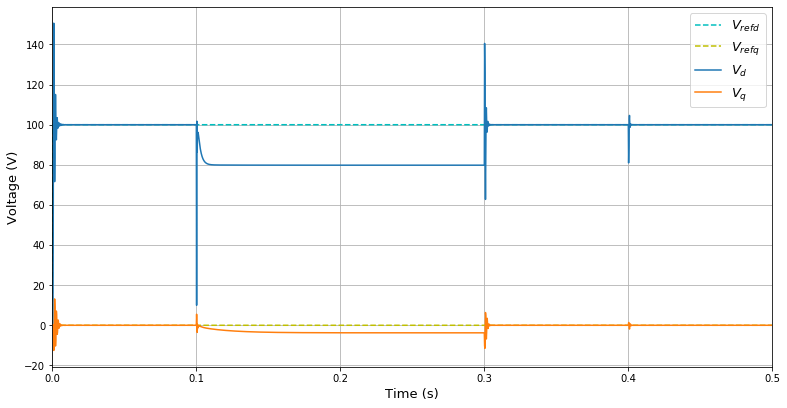

In [107]:
fig = plt.figure(figsize =(10, 5))
 
# Creating plot
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(k[0:2500], rt[0], 'c--', k[0:2500], rt[1], 'y--', k, xt[2], '-', k, xt[3], '-')
ax.legend(['$V_{refd}$', '$V_{refq}$', '$V_d$', '$V_q$'], fontsize=13)
ax.set_xlim(0, 0.5)
plt.ylabel('Voltage (V)', fontsize=13)
plt.xlabel('Time (s)', fontsize=13)
plt.grid(True)

# show plot
plt.show()

In [110]:
fig.savefig("der_voltage.pdf", bbox_inches='tight')

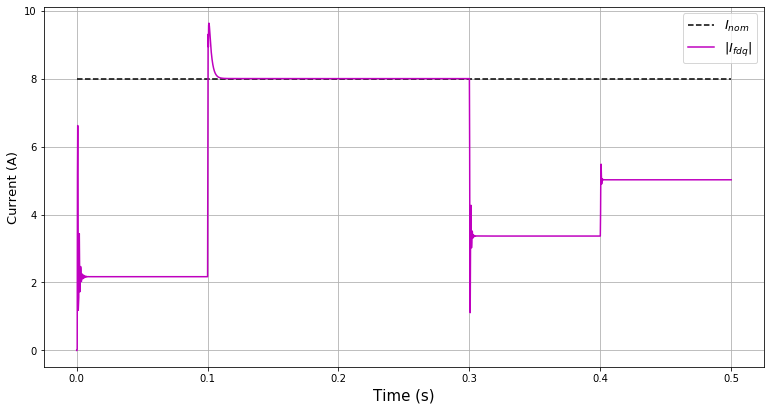

In [109]:
c = np.sqrt(np.add(np.power(xt[0],2), np.power(xt[1],2)))

fig2 = plt.figure(figsize =(10, 5))

# Creating plot
ax2 = fig2.add_axes([0, 0, 1, 1])
ax2.plot([0,0.5], [8,8], 'k--', k, c, 'm-')
ax2.legend(['$I_{nom}$', '$|I_{fdq}|$'], fontsize=13)
ax.set_xlim(0, 0.5)
plt.xlabel('Time (s)', fontsize=15)
plt.ylabel('Current (A)', fontsize=13)
plt.grid(True)

# show plot
plt.show()

In [111]:
fig2.savefig("der_current.pdf", bbox_inches='tight')

In [ ]:
fig3 = plt.figure(figsize =(10, 5))

# Creating plot
ax3 = fig2.add_axes([0, 0, 1, 1])
ax3.plot(k[0:2500], ut[0], k[0:2500], ut[1])
ax3.set(xlabel='time (s)', ylabel='voltage')
plt.grid(True)

# show plot
plt.show()